In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [63]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date, timedelta
import scipy.stats as st

In [64]:
# Reflect tables into SQLAlchemy ORM
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

# Set up automap_base to reflect the database components
Base = automap_base()
Base.prepare(engine, reflect=True)

# Let's take a look at those keys and see what the heck is going on!
Base.classes.keys()

# Assign keys to classes
Measurement = Base.classes.measurement
Station = Base.classes.station

# Start a session to query the database
session = Session(engine)

In [5]:
# Get most recent date
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent


query_date = dt.date(2017, 8, 3) - dt.timedelta(days=365)
print(query_date)
# Remove hard coding, time permitting

2016-08-03


In [25]:
# Temp Analysis I
# Get all temp data (tobs)
# Datetime conversion help from stackoverflow https://stackoverflow.com/questions/25015711/time-data-does-not-match-format

all_temp = session.query(Measurement.date, Measurement.tobs).\
            order_by(Measurement.date.desc()).all()
all_temp = pd.DataFrame(all_temp)
all_temp['date'] =  pd.to_datetime(all_temp['date'], infer_datetime_format=True)
# all_temp.set_index(pd.DatetimeIndex(all_temp['date'])) 
all_temp = all_temp.set_index("date", drop=True)
all_temp

,tobs
date,
2017-08-23,81.0
2017-08-23,82.0
2017-08-23,82.0
2017-08-23,76.0
2017-08-22,82.0
...,...
2010-01-01,72.0
2010-01-01,75.0
2010-01-01,70.0


In [26]:
june = all_temp[all_temp.index.month == 6]
june

december = all_temp[all_temp.index.month == 12]
december

,tobs
date,
2016-12-31,66.0
2016-12-31,71.0
2016-12-31,72.0
2016-12-31,67.0
2016-12-31,65.0
...,...
2010-12-01,72.0
2010-12-01,78.0
2010-12-01,72.0


In [29]:
# T test to compare temp in December and June

st.ttest_ind(june['tobs'], december['tobs'], equal_var=False)

Ttest_indResult(statistic=31.35503692096242, pvalue=4.193529835915755e-187)

With a p-value much smaller than 0.05, and a null hypothesis that there is no difference between the average temperature in June vs the average temperature in December, we can reject the null and conclude that the means are different between June and December. 

In [32]:
# Temp Analysis II
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

# Past climate stats for trip range
print(calc_temps('2015-08-01', '2015-08-07'))

[(62.0, 69.57142857142857, 74.0)]
[(69.0, 78.27272727272727, 85.0)]


In [49]:
# Plot results of historic trip data as a bar chart
results = calc_temps('2015-08-01', '2015-08-07')
tmin = results[0][0]
tavg = results[0][1]
tmax = results[0][2]
y_error_bar = tmax - tmin
print(tmin, tave, tmax, y_error_bar)

69.0 78.27272727272727 85.0 16.0


Text(0.5, 1.0, 'Trip Avg Temp')

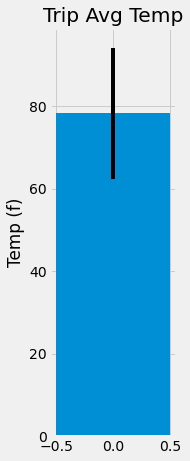

In [53]:
plt.figure(figsize=(2, 7))
plt.bar(0, tavg, yerr=y_error_bar, width=1)
plt.ylabel('Temp (f)')
plt.title('Trip Avg Temp')

In [56]:
# Daily rainfall average

avg_rain = session.query(Measurement.station, func.sum(Measurement.prcp)).\
            filter(Measurement.date>='2015-08-01').\
            filter(Measurement.date<='2015-08-1').\
            group_by(Measurement.station).\
            order_by(func.sum(Measurement.prcp).desc()).all()
avg_rain

[('USC00516128', 2.3000000000000003),
 ('USC00513117', 0.95),
 ('USC00519281', 0.75),
 ('USC00519523', 0.49),
 ('USC00519397', 0.26),
 ('USC00511918', 0.1),
 ('USC00517948', 0.05)]

In [60]:
# Daily Temp Range and Average

# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
print(daily_normals("01-01"))

print(daily_normals("08-01"))

[(62.0, 69.15384615384616, 77.0)]
[(67.0, 75.54, 83.0)]


In [67]:
# Set up variables for start and end dates and a list to hold the historic normals calculated
# Many thanks to Beau Jeffreys for sharing his solution with me 
# Without his help, I'd still be stumbling around timedeltas
start = date(2015, 8, 1)
end = date(2015, 8, 7)

# Pull all dates of trip
trip_dates = []

delta = end - start
for date in range(delta.days +1):
    day = start + timedelta(days=date)
    
    # Remove year
    day = day.strftime('%m-%d')
    trip_dates.append(day)

trip_dates

['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']

In [68]:
# Collect normals

normals = []
for date in trip_dates:
    normals.append(daily_normals(date)[0])
    
print(normals)

[(67.0, 75.54, 83.0), (68.0, 75.60377358490567, 84.0), (70.0, 76.61111111111111, 85.0), (69.0, 76.71153846153847, 84.0), (69.0, 76.14814814814815, 82.0), (67.0, 76.25, 83.0), (71.0, 77.15686274509804, 83.0)]


In [70]:
trip_normals = pd.DataFrame(normals, index=trip_dates, columns=["Min", "Avg", "Max"])
trip_normals

,Min,Avg,Max
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


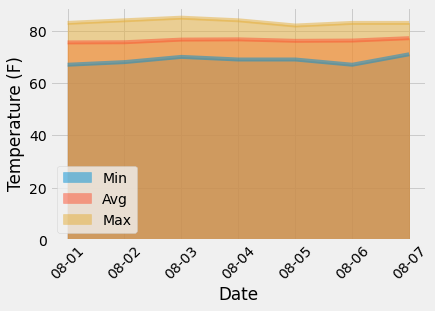

In [76]:
# Plot the daily normals for the trip in an area plot
trip_normals.plot.area(stacked=False, rot=45)
plt.ylabel("Temperature (F)")
plt.xlabel("Date")
plt.show()

In [77]:
session.close()